#### **Welcome to Assignment 11 on Deep Learning for Computer Vision.**
This assignment is based on the content you learned in Week-11 of course. 

#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

# Cycle-GAN

In this assignment we will implement a Cycle-GAN. Please refer to the lecture and the following paper: https://arxiv.org/abs/1703.10593 for an understanding of how Cycle-GAN works.


In [1]:
import math
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import random
import os
import numpy as np
import torchvision.transforms as T
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import itertools

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# Please do not modify anything in this cell

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)  

set_seed(0)

In [3]:
# Please do not modify anything in this cell

def show_images(images):
    images = torch.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

In [4]:
# Please do not modify anything in this cell

dtype = torch.float

# set device

device = torch.device("cuda:0")

## Preparing the data

Cycle-GAN is used to translate data from a source domain to a target domain using unpaired samples from both domains. For this implementation we will consider the problem of translating from the usual MNIST images(bright digits with dark background) to their negatives(dark digits in bright background). Although this is a simple translation that can be achieved by pixed value inversion, it will highlight the working principle of Cycle-GAN. We will prepare the target domain data by manually applying the transformation to the regular MNIST data. Note that the generated data does not have a direct mapping between the images in the source domain and their counter parts in the target domain.

download MNIST if not exist


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



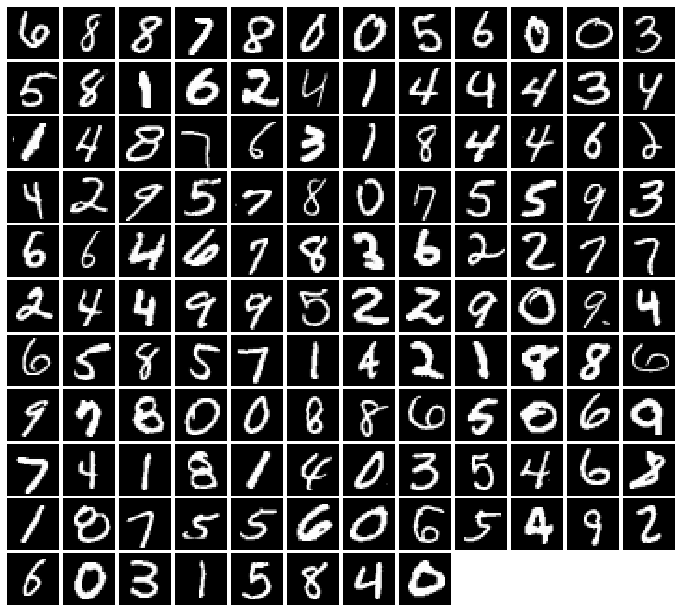

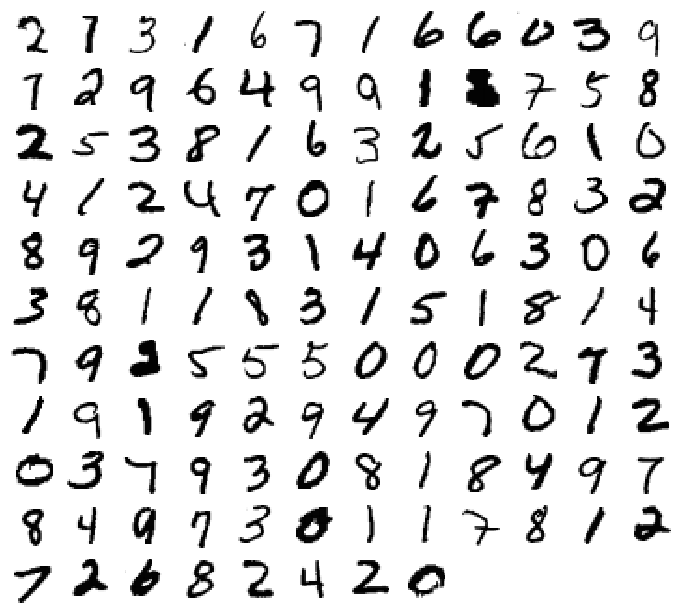

In [5]:
# Please do not modify anything in this cell

# let us load the input images from the dataset and visualize some images!

batch_size = 128

print('download MNIST if not exist')

transform_A = T.Compose([
        T.ToTensor(), # convert the image to a pytorch tensor
        ])

transform_B = T.Compose([
        T.ToTensor(), # convert the image to a pytorch tensor
        lambda x: T.functional.invert(x) # convert images to their negatives
        ])


# source domain data denoted by domain A
mnist_A_train = dset.MNIST('./data', train=True, download=True,
                       transform=transform_A)

loader_A_train = DataLoader(mnist_A_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


# target domain data denoted by doamin B
mnist_B_train = dset.MNIST('./data', train=True, download=True,
                       transform=transform_B)

loader_B_train = DataLoader(mnist_B_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


imgs_A = loader_A_train.__iter__().next()[0].view(batch_size, 784)
imgs_B = loader_B_train.__iter__().next()[0].view(batch_size, 784)

show_images(imgs_A)
show_images(imgs_B)


## Generator and Discriminator

Our Cycle-GAN implementation will contain 2 instances of generators and 1 instance of a discriminator with the following architecture.

### Discriminator

The architecture is:
 * Flatten (Hint: nn.Flatten())
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1 (no activation at output)
  
The output of the discriminator is of shape `[batch_size, 1]`, and contains real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

### Generator

The architecture is:
 * Fully connected layer from 784 to 128
 * `ReLU`
 * Fully connected layer from 128 to 784
 * `TanH` (to clip the image to be in the range of [-1,1])

We will be creating two instances of this generator to go from domain A to B and from B to A respectively. The output of the generators are of shape `[batch_size, 784]`.

In [6]:

def discriminator():
  
  #### YOUR CODE STARTS HERE ####

  # Implement a PyTorch nn.Sequential model for the discriminator architecture given above
  
  model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),  # 1st Fully-Connected layer.
    nn.LeakyReLU(0.01),
    nn.Linear(256, 256),  # 2nd Fully-Connected layer.
    nn.LeakyReLU(0.01),
    nn.Linear(256, 1)     # 3rd Fully-Connected layer.
  )

  #### YOUR CODE ENDS HERE ####

  return model


def generator():

  #### YOUR CODE STARTS HERE ####
    
  # Implement a PyTorch nn.Sequential model for the generator architecture given above

  model = nn.Sequential(
    nn.Linear(784, 128),  # 1st Fully-Connected layer.
    nn.ReLU(),
    nn.Linear(128, 784),        # Hidden layer.
    nn.Tanh()
  )

  #### YOUR CODE ENDS HERE ####

  return model  

## Loss functions

Cycle-GAN involves the generator, discriminator and the cyclic loss. Please refer to the lecture for detailed explanations.

The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
The discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
The cyclic loss is:
$$ \ell_C = -\mathbb{E}_{x \sim p_\text{data}}\left||G_{YX}(G_{XY}(x)- x\right||$$
We will be *minimizing* these losses. We have already implemented the functions to compute generator and discriminator losses. Please go trhough them carefully. You need to write the function for cyclic loss. 

In [7]:
def discriminator_loss(logits_real, logits_fake):
  """
  Computes the discriminator loss described above.
  
  Inputs:
  - logits_real: PyTorch Tensor of shape (batch_size, 1) giving scores for the real data.
  - logits_fake: PyTorch Tensor of shape (batch_size, 1) giving scores for the fake data.
  
  Returns:
  - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
  """
  loss = None
  
  # For the discriminator (D), the true target (y = 1) corresponds to "real" images.
  # Thus, for the scores of real images, the target is always 1 (a vector).
  real_labels = torch.ones_like(logits_real, device=device)
  # Compute the BCE for the scores of the real images.
  # Note that the BCE itself uses the Expectation formula (in addition, an average is
  # taken throughout the losses, not a sum [as requested in this assignment]).
  real_loss = F.binary_cross_entropy_with_logits(logits_real, real_labels)

  # For D, the false target (y = 0) corresponds to "fake" images.
  # Thus, for the scores of fake images, the target is always 0 (a vector).
  fake_labels = torch.zeros_like(logits_fake, device=device)
  # As for the real scores, compute the BCE loss for the fake images.
  fake_loss = F.binary_cross_entropy_with_logits(logits_fake, fake_labels)

  # Sum "real" and "fake" losses.
  # That is, BCE has already taken into account the "negated equation" form,
  # the "log" (in the Expectation) and the "mean" (insetead on the "sum").
  loss = real_loss + fake_loss

  return loss

def generator_loss(logits_fake):
  """
  Computes the generator loss described above.

  Inputs:
  - logits_fake: PyTorch Tensor of shape (batch_size, 1) giving scores for the fake data.
  
  Returns:
  - loss: PyTorch Tensor containing (scalar) the loss for the generator.
  """
  loss = None
  
  # For the generator (G), the true target (y = 1) corresponds to "fake" images.
  # Thus, for the scores of fake images, the target is always 1 (a vector).
  fake_labels = torch.ones_like(logits_fake, device=device)
  # Compute the BCE for the scores of the fake images.
  fake_loss = F.binary_cross_entropy_with_logits(logits_fake, fake_labels)

  # The generator loss is "fake_loss".
  # That is, BCE has already taken into account the "negated equation" form,
  # the "log" (in the Expectation) and the "mean" (insetead on the "sum").
  loss = fake_loss

  return loss

def cycle_loss(original_input, recovered_input):

  """
  Computes the cyclic loss described above.

  Inputs:
  - original_input: PyTorch Tensor of shape (batch_size, 784) represented a batch of input images.
  - recovered_input: PyTorch PyTorch Tensor of shape (batch_size, 784) represented a batch of reconstructed images.
  
  Returns:
  - loss: PyTorch Tensor containing (scalar) the cyclic loss.
  """
  #### YOUR CODE STARTS HERE ####

  # Implement the cyclic loss as the mean pixel-wise absolute value of difference
  # between the original input and recovered input
  # Hint : F.l1_loss  
  loss = F.l1_loss(original_input, recovered_input)

  #### YOUR CODE ENDS HERE ####

  return loss
  

In [8]:
# Please do not modify anything in this cell

# this function will be used to alternatively iterate through the batches in both domains
def alternate(*iters):
    for row in zip(*iters):
       for i in row:
           yield i

## Training

Complete the code below for the main training loop of the Cycle_GAN. 

In [9]:
def run_cycle_gan(D, G_A2B, G_B2A, D_solver, G_solver, C_solver, discriminator_loss, generator_loss, cycle_loss, show_every=250, 
              batch_size=128, num_epochs=10):
  """
  Train a Cycle-GAN!
  
  Inputs:
  - D, : PyTorch model for the discriminator
  - G_A2B, : PyTorch model for the generator that maps from domain A to B
  - G_B2A, : PyTorch model for the generator that maps from domain B to A
  - D_solver, G_solver, C_solver: torch.optim Optimizers to use for training the
    discriminator, generator(from A to B) and both generators(to cycle from A to A and from B to B) 
    respectively.
  - discriminator_loss, generator_loss, cycle_loss : Functions to use for computing the generator loss,
    discriminator loss and cycle loss respectively.
  - show_every: Show samples after every show_every iterations.
  - batch_size: Batch size to use for training.
  - num_epochs: Number of epochs over the training dataset to use for training.
  """
  iter_count = 0
  for epoch in range(num_epochs):
    for x, _ in alternate(loader_A_train, loader_B_train):
      """
      Storing a batch each from domain A and B as real_data_A and
      real_data_B respectively and also normalizing for pixel values to lie in range [-1,1]
      """
      if len(x) != batch_size:
        continue
      if iter_count%2 == 0:
        real_data_A = x.view(-1, 784).to(device)
        real_data_A = 2*(real_data_A - 0.5)
        iter_count += 1
        # go to next batch directly to get domain B data
        continue

      real_data_B = x.view(-1, 784).to(device)
      real_data_B = 2*(real_data_B - 0.5)
        
      """
      With one batch each loaded from both domains, we now train the network to
      minimize all three losses for these two batches.
      """
    
      """
      Optimizing discriminator loss
      """

      #### YOUR CODE STARTS HERE ####

      D_solver.zero_grad()
          
      # compute the classification logits for the real data in B using the discriminator
      logits_real_B = D(real_data_B)

      # generate fake data in domain B from real data in domain A using the Generator 
      # from A to B
        
      fake_data_B = G_A2B(real_data_A).detach()
    
      # compute the classification logits for the fake data in B using the discriminator
      dis_logits_fake_B = D(fake_data_B)

      # compute the discriminator error using the discriminator_loss function defined above 
      # while passing the appropiate params
      d_total_error = discriminator_loss(logits_real_B, dis_logits_fake_B)
      d_total_error.backward()        
      D_solver.step()
        
      """
      Optimizing cylic loss (from A->B->A as well as B->A>B)
      """

      C_solver.zero_grad()
      
      # generate the recovered data in domain A from the fake data generated in domain B
      # using the generator from B to A
      recovered_A = G_B2A(fake_data_B)
    
      # compute the cyclic error between the real data from A and the recovered data from A
      # using the cycle_loss function defined above
      c_error = cycle_loss(real_data_A, recovered_A)
      c_error.backward()
      C_solver.step()
      
      C_solver.zero_grad()
      
      # generate fake data in domain A from real data in domain B using the generator 
      # from B to A
        
      fake_data_A = G_B2A(real_data_B)
    
      # generate the recovered data in domain B from the fake data generated in domain A
      # using the generator from B to A
    
      recovered_B = G_A2B(fake_data_A)
        
      # compute the cyclic error between the real data from B and the recovered data from B
      # using the cycle_loss function defined above
        
      c_error = cycle_loss(real_data_B, recovered_B)
      c_error.backward()
      C_solver.step()
      
        
      """
      Optimizing generator loss for the generator from A to B to fool the discriminator
      """

      G_solver.zero_grad()
      # again generate fake data in domain B from real data in domain A using the
      # generator from A to B 
      fake_data_B = G_A2B(real_data_A)

      # compute the classification logits for the fake data in B using the discriminator
      gen_logits_fake_B = D(fake_data_B)
    
      # compute the generator error using the generator_loss function defined above 
      # while passing the appropiate params
      g_error = generator_loss(gen_logits_fake_B)
      g_error.backward()
      G_solver.step()

      #### YOUR CODE ENDS HERE ####
        
      if (((iter_count-1)/2) % show_every == 0):
        print('Iter: {}, D: {:.4}, G:{:.4}, C:{:.4}'.format((iter_count-1)/2,d_total_error.item(),g_error.item(), c_error.item()))
        
        print('\n Source')
        imgs_numpy = real_data_A.data.cpu()#.numpy()
        show_images(imgs_numpy[0:16])
        plt.show()
        
        print('Target')
        imgs_numpy = fake_data_B.data.cpu()#.numpy()
        show_images(imgs_numpy[0:16])
        plt.show()
       
        print()
      iter_count += 1
 

## Executing the Cycle-GAN

Now run the cell below to train the Cycle-GAN! 

After every 250 iterations you should see a grid of images from domain A (regular MNIST) and a grid of the generated corresponding images in domain B (negative MNIST). Initially many digits in the target grid will differ from the corresponding images in the source grid but will be digits of similar shapes. Finally there should be a correct or near correct translation from the source domain to the target domain.

Iter: 0.0, D: 1.394, G:0.7137, C:0.9454

 Source


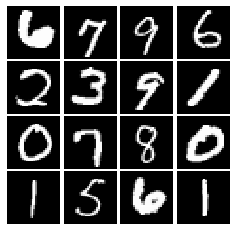

Target


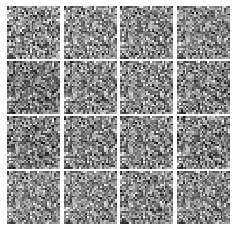


Iter: 250.0, D: 0.9985, G:2.025, C:0.1791

 Source


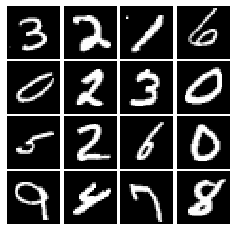

Target


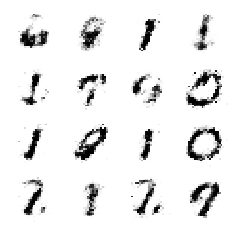


Iter: 500.0, D: 1.04, G:1.364, C:0.1292

 Source


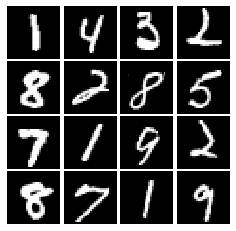

Target


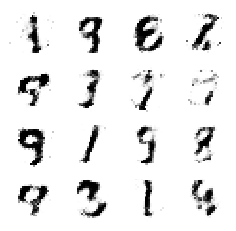


Iter: 750.0, D: 1.103, G:1.247, C:0.1189

 Source


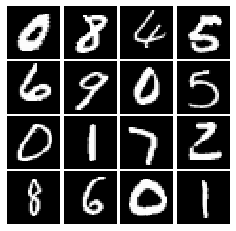

Target


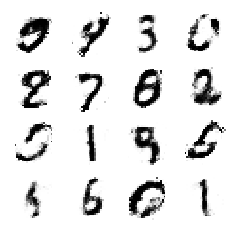


Iter: 1000.0, D: 1.025, G:1.482, C:0.1149

 Source


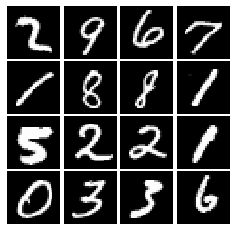

Target


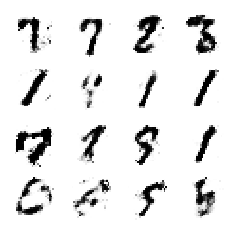


Iter: 1250.0, D: 1.052, G:1.804, C:0.1017

 Source


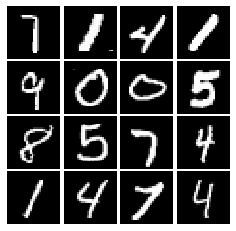

Target


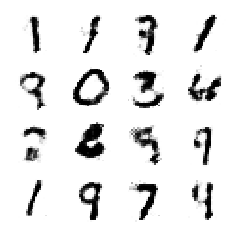


Iter: 1500.0, D: 1.156, G:1.061, C:0.09808

 Source


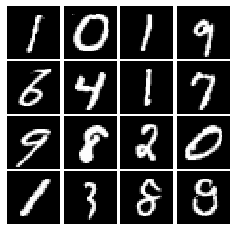

Target


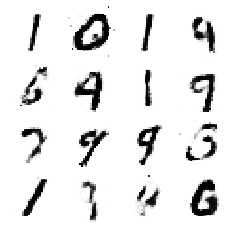


Iter: 1750.0, D: 1.178, G:1.425, C:0.09902

 Source


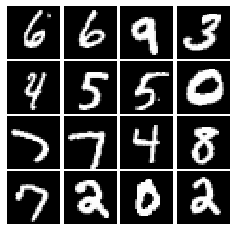

Target


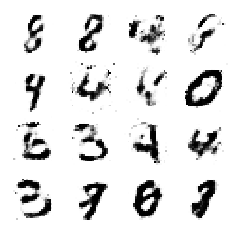


Iter: 2000.0, D: 1.068, G:1.284, C:0.09365

 Source


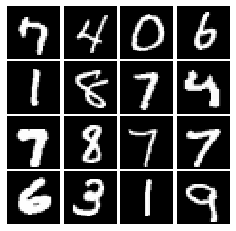

Target


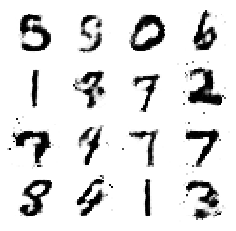


Iter: 2250.0, D: 1.029, G:1.25, C:0.09271

 Source


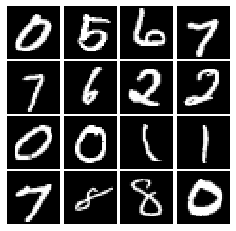

Target


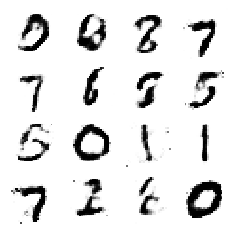


Iter: 2500.0, D: 0.9735, G:1.383, C:0.09096

 Source


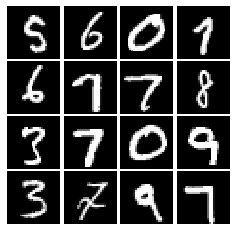

Target


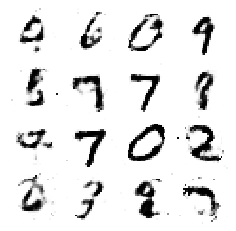


Iter: 2750.0, D: 1.143, G:1.404, C:0.09007

 Source


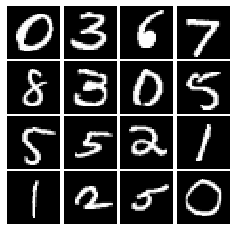

Target


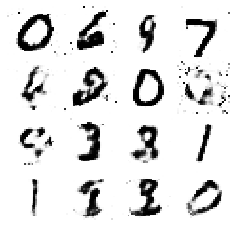


Iter: 3000.0, D: 0.9412, G:1.471, C:0.08469

 Source


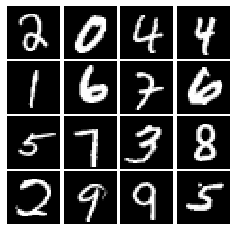

Target


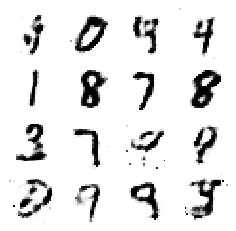


Iter: 3250.0, D: 0.9844, G:1.259, C:0.07998

 Source


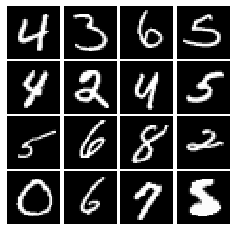

Target


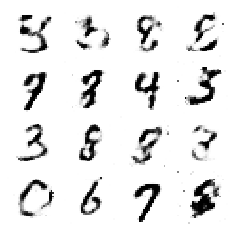


Iter: 3500.0, D: 0.9828, G:1.298, C:0.08376

 Source


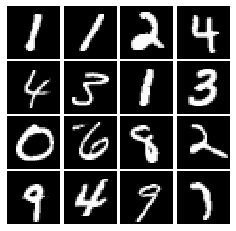

Target


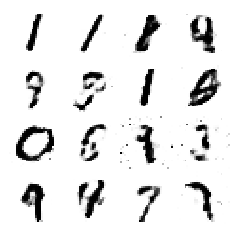


Iter: 3750.0, D: 0.9994, G:1.468, C:0.07674

 Source


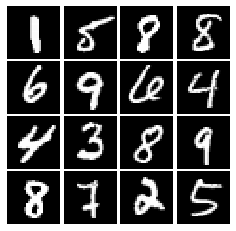

Target


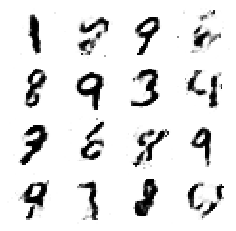


Iter: 4000.0, D: 0.9651, G:1.437, C:0.08356

 Source


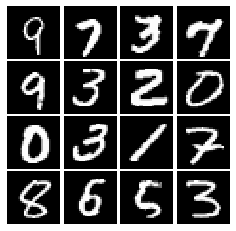

Target


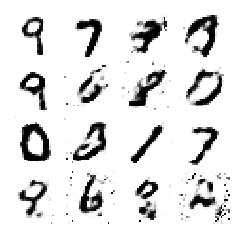


Iter: 4250.0, D: 1.146, G:1.496, C:0.07898

 Source


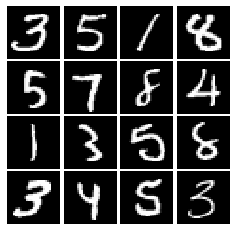

Target


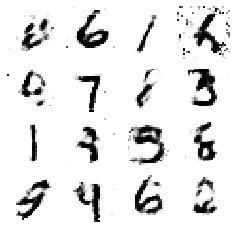


Iter: 4500.0, D: 1.063, G:1.693, C:0.08165

 Source


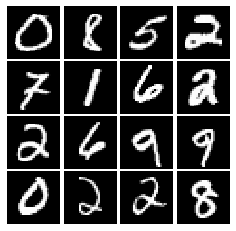

Target


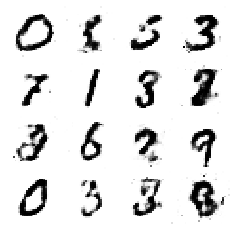

In [10]:
# Please do not modify anything in this cell

set_seed(0)

# Make the discriminator
D = discriminator().to(device)

# Make the generators
G_A2B = generator().to(device)
G_B2A = generator().to(device)


# Create optimizers for the Discriminator and the Generators
D_solver = optim.Adam(D.parameters(), lr=1e-3, betas=(0.5, 0.999))
G_solver = optim.Adam(G_A2B.parameters(), lr=1e-3, betas=(0.5, 0.999))
C_solver = optim.Adam(itertools.chain(G_A2B.parameters(), G_B2A.parameters()), lr=1e-3, betas=(0.5, 0.999))

# Run it!
run_cycle_gan(D, G_A2B, G_B2A, D_solver, G_solver, C_solver, discriminator_loss, generator_loss, cycle_loss)

Now answer the following questions based on the results.

## Question 1

What is the range of final discriminator error displayed in the cell? (choose the closest answer)

1. 0-0.99 
2. 1-1.99 (Correct Answer)
3. 2-2.99
4. 3-3.99

## Question 2

What is the range of final generator error displayed in the cell? (choose the closest answer)

1. 0-0.99 
2. 1-1.99 (Correct Answer)
3. 2-2.99
4. 3-3.99

## Question 3

What is the range of final cyclic error displayed in the cell? (choose the closest answer)

1. 0-0.99 (Correct Answer)
2. 1-1.99 
3. 2-2.99
4. 3-3.99